In [7]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

sys.path.append(r'C:\Users\avido\Documents\other code\AlgoTrading')
import utils

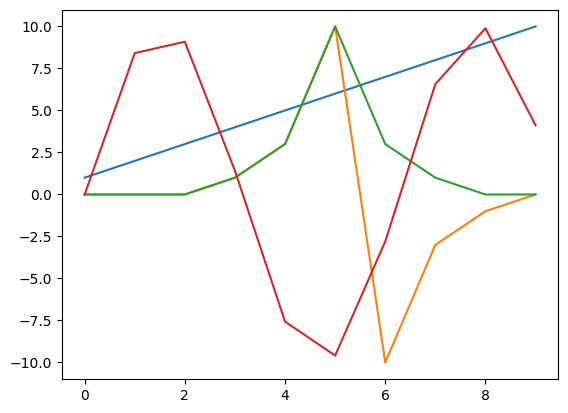

In [8]:
b1 = [1,2,3,4,5,6,7,8,9,10]
b2 = [0, 0, 0, 1, 3, 10,-10, -3, -1, 0]
b3 = [0, 0, 0, 1, 3, 10, 3, 1, 0, 0]
b4 = [np.sin(x) * 10 for x in range(10)]

bases = [b1, b2, b3, b4]

for b in bases:
    plt.plot(b)

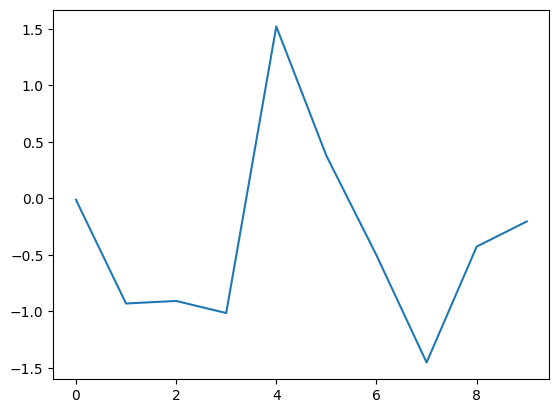

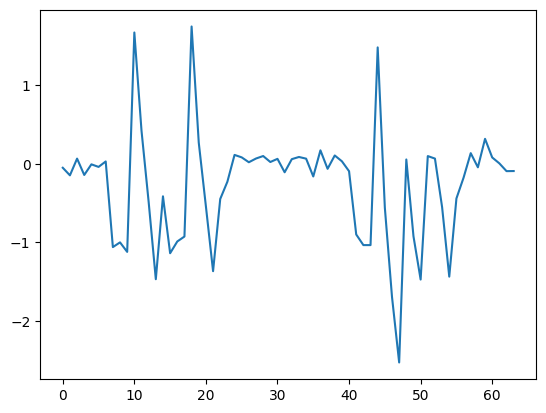

In [109]:
def generate_random_basis_combo(bases, out_len = 64, max_n_bases = 10, noise = .1):
    n_bases = np.random.randint(1, max_n_bases)
    out = np.zeros(out_len)
    for i in range(n_bases):
        base_idx = np.random.randint(0, len(bases))
        base = bases[base_idx]
        random_start = np.random.randint(0,  out_len - len(base))
        out[random_start:random_start+len(base)] += base
    out += np.random.randn(out_len) * noise
    return out

def generate_random_bases(n_bases, base_len = 64):
    bases = []
    for i in range(n_bases):
        base = np.random.randn(base_len)
        bases.append(base)
    return bases

bases= generate_random_bases(1, base_len = 10)
for base in bases:
    plt.plot(base)
plt.show()
plt.plot(generate_random_basis_combo(bases))      
  


In [110]:
class dataset(Dataset):
    def __init__(self, bases, out_len = 64, max_n_bases = 10, noise = .1):
        self.bases = bases
        self.out_len = out_len
        self.max_n_bases = max_n_bases
        self.noise = noise

    def __len__(self):
        return 1000

    def __getitem__(self, idx):
        sample = generate_random_basis_combo(self.bases, self.out_len, self.max_n_bases, self.noise)
        sample = (sample - sample.mean()) / sample.std()
        sample = torch.tensor(sample).type(torch.float32).unsqueeze(0)
        return sample

batch_size = 1028
train_dl = DataLoader(dataset(bases, noise = 0), batch_size=batch_size, shuffle=True)

In [111]:
itrtr = iter(train_dl)
x = next(itrtr)
x.shape

torch.Size([1000, 1, 64])

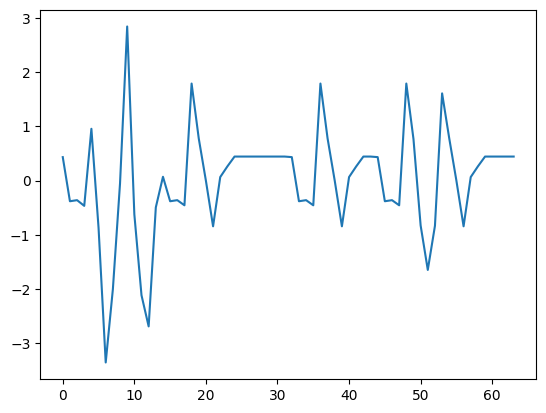

In [112]:
#plot random sample
rand_idx = np.random.randint(0, len(x))
plt.plot(x[rand_idx][0].numpy())

In [113]:
# CNN Autoencoder

class Autoencoder(nn.Module):
    def __init__(self, out_dim):
        super(Autoencoder, self).__init__()
        self.out_dim = out_dim
        # Encoder
        self.enc1 = nn.Conv1d(1, 256, kernel_size=10, stride=1, padding=1)
        # self.enc2 = nn.LazyLinear(512) 
        # self.enc3 = nn.LazyLinear(512)
        # self.enc4 = nn.LazyLinear(512) 
        # self.enc5 = nn.LazyLinear(out_dim) 
        self.enc2 = nn.Conv1d(256, 128, kernel_size=10, stride=1, padding=1)
        self.enc3 = nn.Conv1d(128, 64, kernel_size=10, stride=1, padding=1)
        self.enc4 = nn.Conv1d(64, 1, kernel_size=10, stride=1, padding=1)

    def forward(self, x):
        # Encoder
        x = F.relu(self.enc1(x))
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = self.enc5(x)
        return x
        

    
#test encoder on dataloader
model = Autoencoder(64)
# model = Autoencoder()
y = model(next(iter(train_dl)))

# model = Encoder(4)
# y = model(next(iter(train_dataloader)))
y.shape

c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([1000, 64])

In [114]:
def train_loop(model, dataloader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        inputs = data
        inputs = inputs.to(device)  # Move the inputs to the device (GPU or CPU)

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, inputs)  # Compute the loss

        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        running_loss += loss.detach().item()
        print(f"Train epoch: Percent complete: {100 * i / len(dataloader)}", end='\r')
    return running_loss / len(dataloader)



In [115]:
out_dim = 64
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Autoencoder(out_dim).to(device) # GPU
loss_fn = nn.MSELoss()

val_losses = []
train_losses = []



In [116]:
num_epochs = 10000
learning_rate = .001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    train_loss = train_loop(model, train_dl, loss_fn, optimizer, device)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}")
    
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')

c:\Users\avido\Documents\other code\AlgoTrading\.venv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1000, 1, 64])) that is different to the input size (torch.Size([1000, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10000, Train Loss: 1.002528190612793
Epoch 2/10000, Train Loss: 1.3190544843673706
Epoch 3/10000, Train Loss: 0.9939632415771484
Epoch 4/10000, Train Loss: 0.9920949935913086
Epoch 5/10000, Train Loss: 0.9890437126159668
Epoch 6/10000, Train Loss: 0.9900217652320862
Epoch 7/10000, Train Loss: 0.9879561066627502
Epoch 8/10000, Train Loss: 0.988486111164093
Epoch 9/10000, Train Loss: 0.987694263458252
Epoch 10/10000, Train Loss: 0.9876831769943237
Epoch 11/10000, Train Loss: 0.98861163854599
Epoch 12/10000, Train Loss: 0.9881055951118469
Epoch 13/10000, Train Loss: 0.9885202646255493
Epoch 14/10000, Train Loss: 0.9869837760925293
Epoch 15/10000, Train Loss: 0.987237274646759
Epoch 16/10000, Train Loss: 0.9877512454986572
Epoch 17/10000, Train Loss: 0.9874566197395325
Epoch 18/10000, Train Loss: 0.9857508540153503
Epoch 19/10000, Train Loss: 0.9858957529067993
Epoch 20/10000, Train Loss: 0.9864446520805359
Epoch 21/10000, Train Loss: 0.987607479095459
Epoch 22/10000, Train Loss: 0

KeyboardInterrupt: 

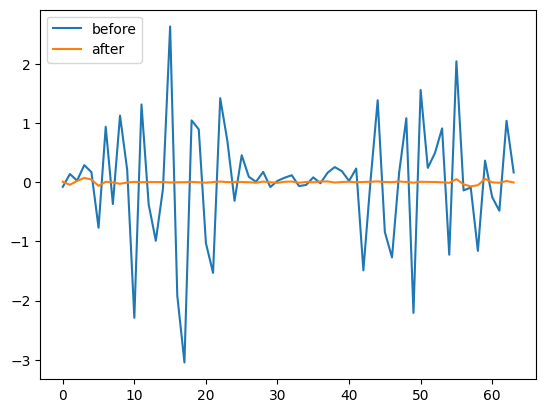

In [108]:
# show example before and after model
model.eval()
with torch.no_grad():
    x = next(iter(train_dl))
    x = x.to(device)
    y = model(x)
    x = x.cpu()
    y = y.cpu()
    rand_idx = np.random.randint(0, len(x))
    plt.plot(x[rand_idx][0].numpy(), label='before')
    plt.plot(y[rand_idx].numpy(), label='after')
    plt.legend()
    plt.show()

In [42]:
y

tensor([[0.0074, 0.0066, 0.0167,  ..., 0.0283, 0.0173, 0.0229],
        [0.0136, 0.0120, 0.0214,  ..., 0.0419, 0.0295, 0.0304],
        [0.0168, 0.0155, 0.0292,  ..., 0.0527, 0.0311, 0.0395],
        ...,
        [0.0145, 0.0147, 0.0282,  ..., 0.0493, 0.0331, 0.0396],
        [0.0152, 0.0142, 0.0295,  ..., 0.0455, 0.0334, 0.0347],
        [0.0214, 0.0223, 0.0384,  ..., 0.0562, 0.0475, 0.0440]])